In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
# Importing package for KMeans algorithm
from sklearn.cluster import KMeans

# Feature extraction using SIFT
# takes list of images as input
# returns array of sift descriptors as ddescribed in task 
def extract_features(data):
    
    features = np.zeros((0, 128))
    
    for i in range(len(data)):
        im = data[i]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        features = np.vstack((features, des))
                
    return features

# Running k_means and getting clusters
# take features from function above
# return vocabulary
def cluster_features(features, k=200):
    
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    return kmeans.cluster_centers_

# print(f"FEATURES:\n{features}")
# print(f"CLUSTERS:\n{clusters}")

In [3]:
#input clusters and data that is just and array of images
def bag_of_words(clusters, data, idf=True):
    # gets bag of words for each image in data
    all_bags = []
    for i in range(len(data)):
        im = data[i] # [0]
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(im,None)
        #print(des)
        
        # get histogram of clusters / bag of words for one image
        bag_of_words = np.zeros(len(clusters))
        for d in des:
            distances = np.linalg.norm(clusters - d, axis=1)
            bag_of_words[np.argmin(distances)] += 1
        all_bags.append(bag_of_words)
    
    if idf:
        bags_array = np.array(all_bags)
        bags_array[bags_array != 0] = 1
        
        idf_w = np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))
        #print(np.min(np.log(bags_array.shape[1] / np.sum(bags_array, axis=0))))
        #print(all_bags[0])
        all_bags = [bag * idf_w for bag in all_bags]        
        #print(all_bags[0])
            
        
    return all_bags

#bags = bag_of_words(clusters, train)

In [15]:
import pandas as pd
category_tables = []

def make_table():
    #file name, true category, training/test set, word histogram
    table = {"file_name" : [],
             "category" : [],
             "test-train" : [],
             "im" : [],
             "hist": []}
    
    #get categories
    dir_list = []
    for dirs in os.listdir("caltech-101/101_ObjectCategories/"):
        dir_list.append(os.path.join("caltech-101/101_ObjectCategories", dirs))
        
    random.Random(6).shuffle(dir_list)      
    random_categories = dir_list[:1] 

    
    #get images from each category
    for category in random_categories:
        # get files in each category
        for file in os.listdir(category):
            table["file_name"] = table.get("file_name", []) + [file]
            table["category"] = table.get("category", []) + [category.split("/")[-1]]
            im = cv2.imread(os.path.join(category, file))
            gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            table["im"] = table.get("im", []) + [gray]
            
    # shuffle data and split into train and test
    test_train = []
    
    if len(table.get("category")) % 2 == 0:
        half = int(len(table.get("category")) / 2)
        #test_train = ["test"] * half + ["train"] * half
        test_train = ["test", "train"] * half

    else:
        half = int(len(table.get("category")) / 2)
        test_train = ["test", "train"] * half + ["train"]

    #random.Random(5).shuffle(test_train)
    
    table["test-train"] = test_train
        
    return table
    
table = make_table()

train = []
test = []

for i in range(len(table["test-train"])):
    test_train = table["test-train"]
    im = table["im"]
    
    if test_train[i] == "test":
        test.append(im[i])
    elif test_train[i] == "train":
        train.append(im[i])
        
# Gather descriptors in training image data set
features = extract_features(train)
# get vocabulary
clusters = cluster_features(features, k=300)

#create bags of words for each image
table["hist"] = bag_of_words(clusters, table["im"], idf=True)

In [12]:
'''
    Gennemløb alle kategorier
    For hver kategori
        skaf alle billeder og split dem i train og test set
        for hvert billede i directory
'''

# Importing packages
import pandas as pd
from sklearn.model_selection import train_test_split

# List of tables
category_tables = []

# Function for generating table
def gen_table(path):
    # Current table
    this_table = {
        "file_name":[],
        "category":[],
        "train-test":[],
        "im":[],
        "hist":[],
    }

    # Retrieve images
    images = os.listdir(path)
    #print(images)

    # Train-test division
    train, test = train_test_split(images, test_size=0.5, random_state=42)
    conv_train = [cv2.imread(os.path.join(path, file)) for file in train]
    conv_test = [cv2.imread(os.path.join(path, file)) for file in test]

    for file in os.listdir(path):
        # File name
        this_table["file_name"] = this_table.get("file_name", []) + [file]
        # Category
        this_table["category"] = this_table.get("category", []) + [path.split("/")[-1]]
        # Image
        im = cv2.imread(os.path.join(path, file))
        im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        this_table["im"] = this_table.get("im", []) + [im_gray]
        # train or test
        train_test = "train" if file in train else "test"
        this_table["train-test"] = this_table.get("train-test", []) + [train_test]
    
    features = extract_features(conv_train)
    clusters = cluster_features(features, k=300)
    this_table["hist"] = bag_of_words(clusters, this_table["im"], idf=True)


    category_tables.append(this_table)

# Categories and categories paths
category_limit = 5
category_path = "caltech-101/101_ObjectCategories"
categories = os.listdir(f"{category_path}/")[:category_limit]
category_dir_list = [os.path.join(category_path, category) for category in categories]

# Looping category_dir_list + generating table
for category_dir in category_dir_list:
    gen_table(category_dir)


In [13]:
# df_list = [pd.DataFrame(table) for table in category_tables]
# merged_tables = pd.concat(df_list)
# merged_tables

tb = pd.DataFrame(category_tables[1])
tb

,file_name,category,train-test,im,hist
0,image_0032.jpg,hawksbill,test,"[[88, 95, 96, 88, 89, 97, 97, 90, 93, 92, 90, ...","[2.99817971053047, 7.06661516753905, 4.0412209..."
1,image_0026.jpg,hawksbill,train,"[[64, 64, 64, 65, 65, 66, 66, 66, 66, 67, 68, ...","[2.99817971053047, 0.0, 2.694147295933219, 0.0..."
2,image_0027.jpg,hawksbill,train,"[[68, 67, 56, 39, 29, 31, 33, 31, 35, 40, 42, ...","[0.0, 4.23996910052343, 5.388294591866438, 10...."
3,image_0033.jpg,hawksbill,train,"[[144, 146, 148, 149, 150, 151, 153, 155, 156,...","[0.0, 0.0, 1.3470736479666094, 0.0, 0.0, 2.719..."
4,image_0019.jpg,hawksbill,test,"[[56, 102, 148, 223, 174, 144, 171, 136, 133, ...","[2.99817971053047, 5.65329213403124, 1.3470736..."
...,...,...,...,...,...
95,image_0014.jpg,hawksbill,test,"[[75, 74, 73, 71, 71, 72, 73, 74, 77, 77, 78, ...","[7.495449276326175, 9.89326123455467, 1.347073..."
96,image_0016.jpg,hawksbill,test,"[[34, 34, 33, 33, 33, 34, 35, 36, 33, 33, 33, ...","[0.0, 0.0, 0.0, 1.4411025976148855, 0.0, 0.0, ..."
97,image_0002.jpg,hawksbill,train,"[[153, 166, 171, 165, 160, 164, 165, 162, 143,...","[7.495449276326175, 1.41332303350781, 1.347073..."
98,image_0003.jpg,hawksbill,train,"[[92, 91, 90, 89, 90, 91, 93, 94, 96, 96, 96, ...","[1.499089855265235, 2.82664606701562, 0.0, 0.0..."


In [14]:
def common_words(hist1, hist2):
    min = np.minimum(hist1, hist2)
    return -np.sum(min)

def euclidian(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)

    return np.linalg.norm(hist1 - hist2)

def bhattacharyya(hist1, hist2):
    hist1 = hist1 / np.linalg.norm(hist1)
    hist2 = hist2 / np.linalg.norm(hist2)
    
    return np.sum((hist1*hist2)**.5)

def retrieve(df,  measure, retrieve=0):
    retrieval_img = df.iloc[retrieve]
    print(retrieval_img)
    
    distances = []
    for index, row in df.iterrows():
        dist = measure(retrieval_img.loc["hist"], row.loc["hist"])
        distances.append((dist, index))
    
    distances = sorted(distances, key = lambda x:x[0])
    
    indexes = [dist[1] for dist in distances]
    
    #return merged_tables.iloc[indexes]
    return tb.iloc[indexes]
        

#results = retrieve(merged_tables, measure=euclidian, retrieve=0)
results = retrieve(tb, measure=euclidian, retrieve=0)
results.iloc[:20]

file_name                                        image_0032.jpg
category                                              hawksbill
train-test                                                 test
im            [[88, 95, 96, 88, 89, 97, 97, 90, 93, 92, 90, ...
hist          [2.99817971053047, 7.06661516753905, 4.0412209...
Name: 0, dtype: object


,file_name,category,train-test,im,hist
0,image_0032.jpg,hawksbill,test,"[[88, 95, 96, 88, 89, 97, 97, 90, 93, 92, 90, ...","[2.99817971053047, 7.06661516753905, 4.0412209..."
84,image_0012.jpg,hawksbill,train,"[[4, 13, 17, 23, 30, 25, 21, 29, 53, 55, 58, 6...","[5.99635942106094, 4.23996910052343, 12.123662..."
48,image_0068.jpg,hawksbill,train,"[[193, 160, 127, 145, 185, 202, 146, 144, 149,...","[0.0, 2.82664606701562, 1.3470736479666094, 1...."
71,image_0088.jpg,hawksbill,train,"[[228, 247, 250, 253, 250, 242, 245, 253, 252,...","[2.99817971053047, 1.41332303350781, 5.3882945..."
29,image_0078.jpg,hawksbill,train,"[[56, 64, 56, 85, 100, 58, 48, 73, 111, 82, 86...","[1.499089855265235, 2.82664606701562, 1.347073..."
51,image_0082.jpg,hawksbill,train,"[[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 4,...","[2.99817971053047, 2.82664606701562, 5.3882945..."
73,image_0063.jpg,hawksbill,test,"[[75, 76, 78, 80, 80, 80, 79, 78, 77, 77, 78, ...","[0.0, 0.0, 2.694147295933219, 1.44110259761488..."
31,image_0052.jpg,hawksbill,test,"[[1, 1, 1, 1, 1, 0, 0, 1, 2, 6, 2, 1, 1, 15, 1...","[1.499089855265235, 5.65329213403124, 4.041220..."
50,image_0083.jpg,hawksbill,train,"[[4, 3, 1, 0, 1, 2, 2, 2, 7, 1, 40, 36, 28, 40...","[5.99635942106094, 1.41332303350781, 6.7353682..."
52,image_0096.jpg,hawksbill,train,"[[40, 45, 44, 36, 31, 32, 32, 29, 35, 31, 40, ...","[2.99817971053047, 2.82664606701562, 0.0, 1.44..."


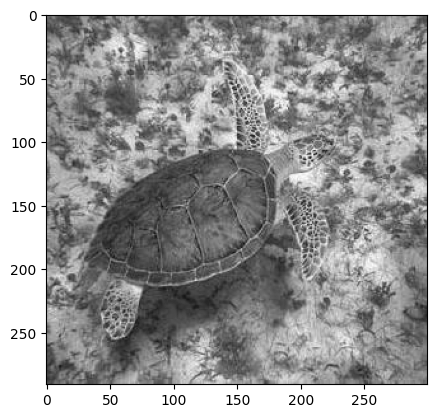

In [16]:
plt.imshow(results.iloc[16]["im"], cmap="gray", vmin=0, vmax=255)

<BarContainer object of 300 artists>

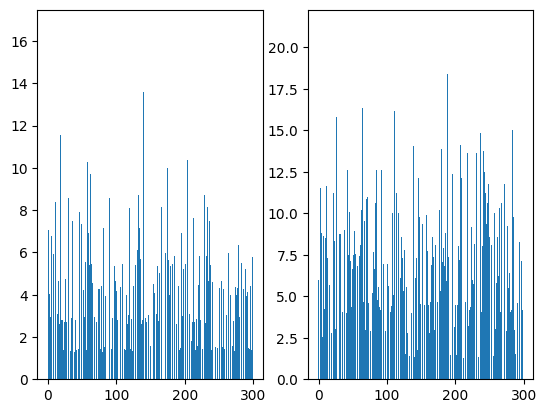

In [18]:
# clusters length
'''
    Filler code for testing
'''
images = os.listdir("caltech-101/101_ObjectCategories/hawksbill/")
train, test = train_test_split(images, test_size=0.5, random_state=42)
examples = [cv2.imread(os.path.join("caltech-101/101_ObjectCategories/hawksbill/", file)) for file in train]
features = extract_features(examples)
clusters = cluster_features(features, k=300)

#plot histograms
plt.subplot(1, 2, 1)
plt.bar(np.arange(0, len(clusters)), results.iloc[0]["hist"])
plt.subplot(1, 2, 2)
plt.bar(np.arange(0, len(clusters)), results.iloc[1]["hist"])